# Stitching thermal drone imagery

In [1]:
# Variable definition
imgDir = 'data/lsm/Flight 1 - Library/'
pathFile = 'data/lsm/Flight 1.csv'
utcDiff = -1
pathColumns = ['timestamp','latitude','longitude','altitude(m)','temperature(F)']
minAlt, maxAlt, altCol = 119.7, 120.3, 'altitude(m)'
imgTimes = [1619811011923,1619811099149] # Specify times if wanted
utmZone, hemisphere = '31n', 'north'
pxSize = 0.27 # pixel size (m) - for now
resolutions = [2, 6, 60]

In [30]:
imgs

['data/lsm/Flight 1 - Library/20210430_202920_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202921_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202922_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202923_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202924_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202925_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202926_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202927_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202928_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202929_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202931_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202932_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202933_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202934_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202935_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202936_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202937_R.jpg',
 'data/lsm/Flight 1 - Library/20210430_202938_R.jpg',
 'data/lsm/Flight 1 - Librar

In [2]:
# Import packages
#%pip install opencv-python
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
#import cv2 as cv

In [3]:
## Retrieve images and path information
imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(('.jpg','.png','.tif'))]
imgs.sort()
pathDf = pd.read_csv(pathFile)

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


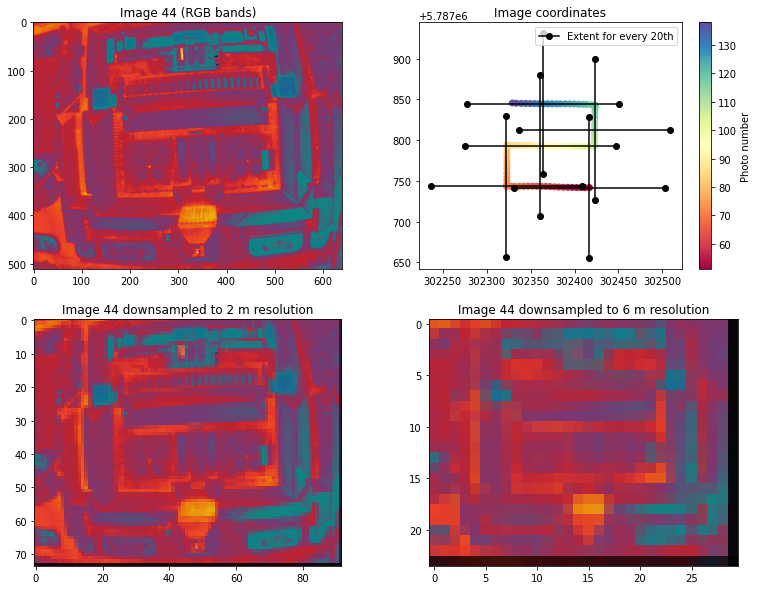

In [4]:
## Get corresponding GPS info matched with images
# Extract date and time from filenames
imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
# Convert to unix datetime 
imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+imgdates[i][:2]),int(imgdates[i][2:4]),int(imgdates[i][4:6]),int(imgtimes[i][:2])+utcDiff,int(imgtimes[i][2:4]),int(imgtimes[i][4:6])))) for i in range(len(imgs))])*1000
# Get nearest GPS timestamp
gpstimes = [min(pathDf['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes]
# Create image dataframe
imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
imgDf['timestamp'] = imgDf['timestamp'].astype(float)

# Merge with path dataframe
merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
# Filter for acceptable measurement altitudes
merged = merged.loc[(merged[altCol] > minAlt) & (merged[altCol] < maxAlt)]
if imgTimes: merged = merged.loc[(merged['timestamp'] > imgTimes[0]) & (merged['timestamp'] < imgTimes[1])]

# Convert coordinates to UTM
myProj = Proj('+proj=utm +zone='+utmZone+', +'+hemisphere+' +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
merged['x'], merged['y'] = myProj(merged['longitude'].values, merged['latitude'].values)

# Plot example image
imageNum = 44
fig, axs = plt.subplots(2,2,figsize=[13,10])
imgEx = ro.open(merged.iloc[44]['imgPath'])
imgExArr = np.dstack((imgEx.read()[0],imgEx.read()[1],imgEx.read()[2]))
a = axs[0,0].imshow(imgExArr.astype(np.uint8))
axs[0,0].set_title('Image {} (RGB bands)'.format(imageNum))

# Plot route
skip = 20
b = axs[0,1].scatter(merged.x,merged.y,c=merged.index, cmap='Spectral')
size = np.array(imgExArr.shape[:2])*pxSize/2
for i, row in merged[::skip].iterrows():
    axs[0,1].plot([row.x-size[1], row.x+size[1]], [row.y, row.y],'k-o')
    axs[0,1].plot([row.x, row.x],[row.y-size[1], row.y+size[1]],'k-o')
axs[0,1].set_title('Image coordinates')
axs[0,1].legend(labels=['Extent for every {}th'.format(skip)])
fig.colorbar(b, ax=axs[0,1],label='Photo number')

# Plot example downsampled image
for i, val in enumerate(resolutions):
    downsample = int(np.floor(val/pxSize))
    # first, change to 0-1
    ds_array = imgExArr/255
    r = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
    g = block_reduce(ds_array[:, :, 1], (downsample, downsample), np.mean)
    b = block_reduce(ds_array[:, :, 2], (downsample, downsample), np.mean)
    ds_array = np.stack((r, g, b), axis=-1)
    if i<2:
        c = axs[1,i].imshow(ds_array)
        axs[1,i].set_title('Image {} downsampled to {} m resolution'.format(str(imageNum),val))
plt.show()
fig.savefig('plots/Image{}.png'.format(str(imageNum)))

## OpenCV stitching

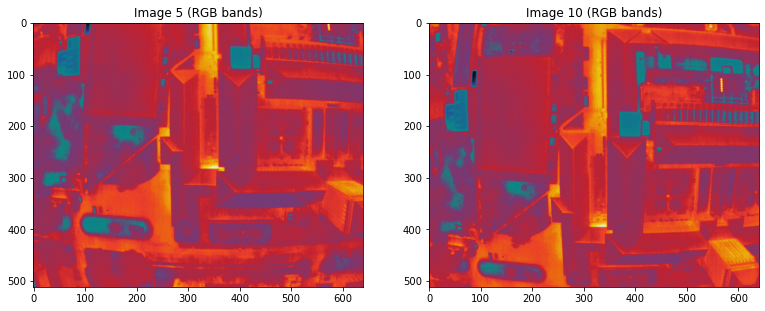

In [7]:
fig, axs = plt.subplots(1,2,figsize=[13,5])
for i, val in enumerate([5,10]):
    imgEx = ro.open(merged.iloc[val]['imgPath'])
    imgExArr = np.dstack((imgEx.read()[0],imgEx.read()[1],imgEx.read()[2]))
    a = axs[i].imshow(imgExArr.astype(np.uint8))
    axs[i].set_title('Image {} (RGB bands)'.format(val))

In [9]:
%pip install imutils opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

  Using cached opencv_python-4.5.2.54-cp37-cp37m-manylinux2014_x86_64.whl (51.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [40]:
trainImg.meta

Dict([('jfif', 258),
      ('jfif_version', (1, 2)),
      ('dpi', (96, 96)),
      ('jfif_unit', 1),
      ('jfif_density', (96, 96)),
      ('exif',
       b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x0e\x00\x0f\x01\x02\x00\x18\x00\x00\x00\xc6\x00\x00\x00\x10\x01\x02\x00 \x00\x00\x00\xde\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00\xb6\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00\xbe\x00\x00\x00(\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x001\x01\x02\x00\x10\x00\x00\x00\xfe\x00\x00\x00\x13\x02\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x9d\x82\x05\x00\x01\x00\x00\x00\x0e\x01\x00\x00i\x87\x04\x00\x01\x00\x00\x00.\x01\x00\x00%\x88\x04\x00\x01\x00\x00\x00X\x07\x00\x00\n\x92\x05\x00\x01\x00\x00\x00\x16\x01\x00\x00\x0e\xa2\x05\x00\x01\x00\x00\x00\x1e\x01\x00\x00\x0f\xa2\x05\x00\x01\x00\x00\x00&\x01\x00\x00\x10\xa2\x03\x00\x01\x00\x00\x00\x04\x00\x00\x00N\x08\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00FLIR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

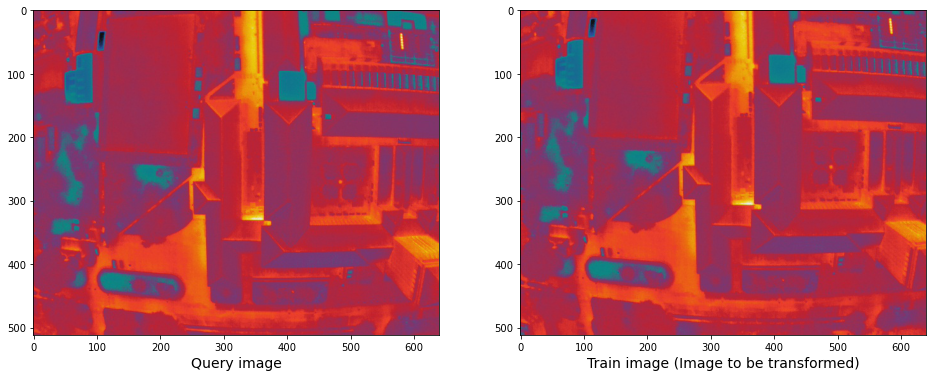

In [31]:
usedImgs = [6,7]
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
trainImg = imageio.imread(merged.iloc[usedImgs[0]]['imgPath'])
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread(merged.iloc[usedImgs[1]]['imgPath'])
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [22]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [23]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

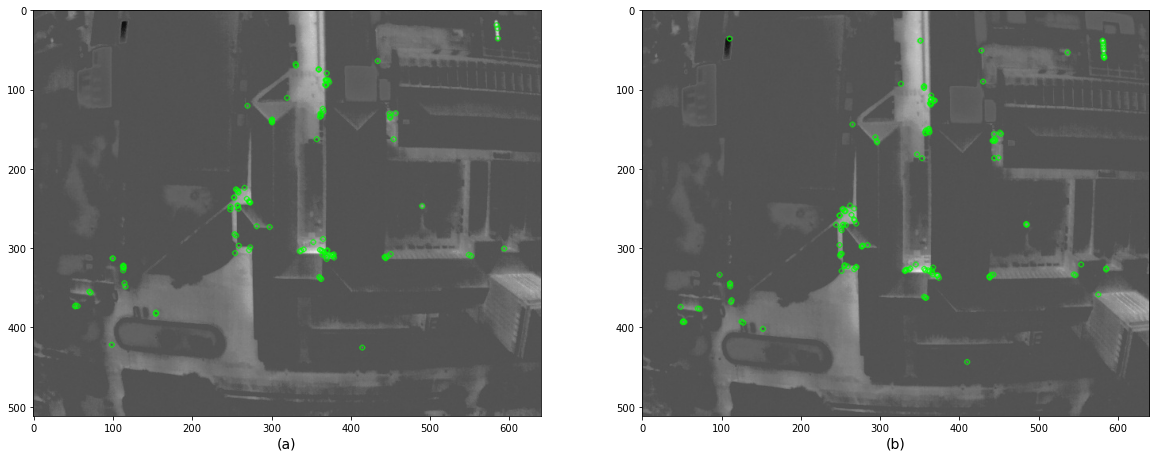

In [24]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [25]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 72


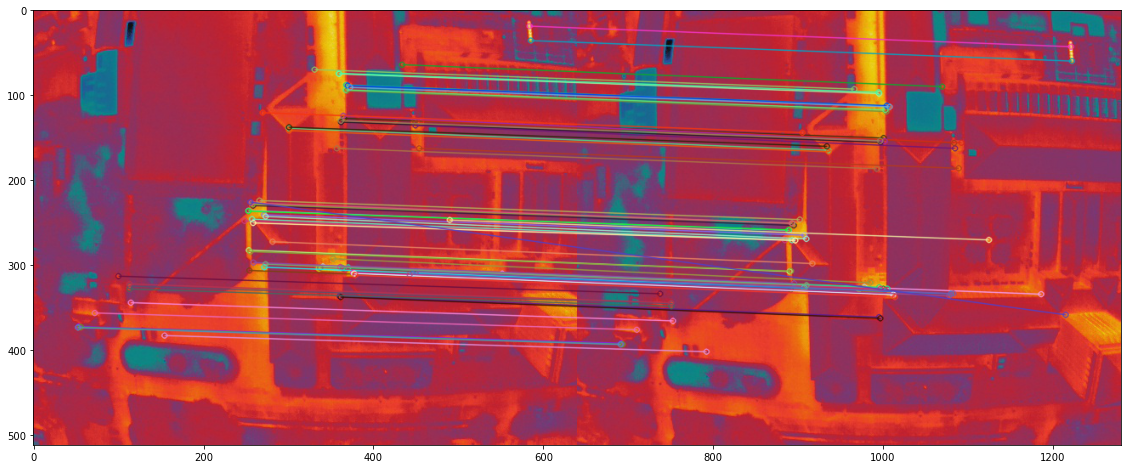

In [26]:
feature_extractor = 'brisk'
feature_matching = 'bf'
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

In [27]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [28]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 1.00181646e+00  1.85488927e-02 -6.38538011e+00]
 [ 6.63061161e-03  1.02308340e+00  1.95299689e+01]
 [-5.76668413e-06  5.27913864e-05  1.00000000e+00]]


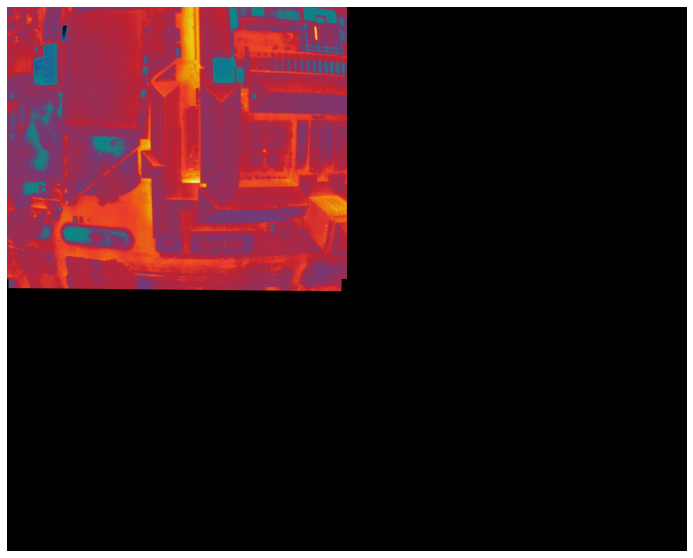

In [29]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

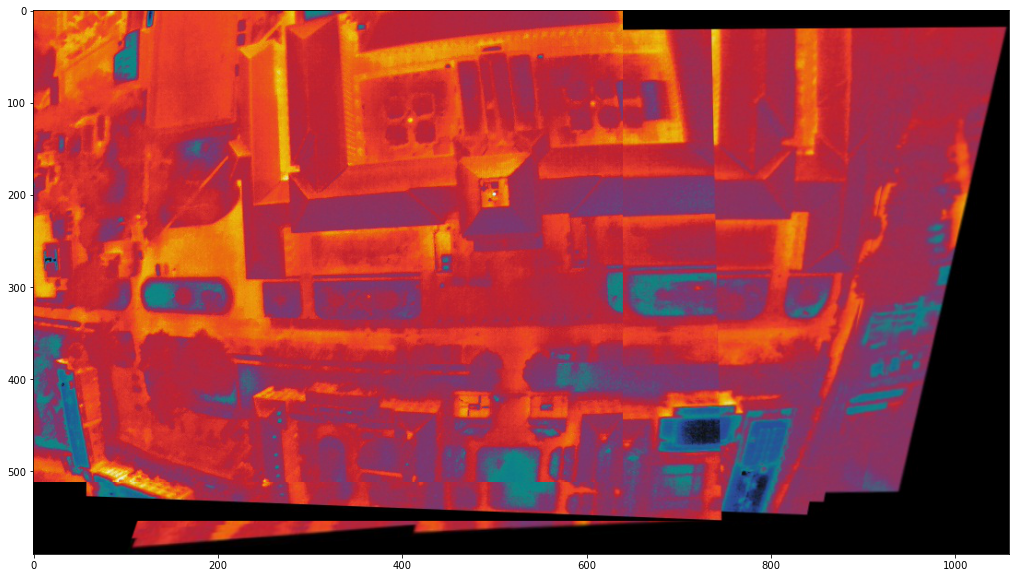

In [211]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

In [212]:
image_to_write = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite("plots/stitch53-75.jpg", image_to_write)

True